## Measuring distances to the PAL5 globular cluster

Author: Luke Bischoff<br>
Created: 03 DEC 2020<br>
Last updated: 04 DEC 2020

##### Introduction
This notebook aims to find distances to RR Lyrae variable stars in the Palomar 5 globular cluster using images from the 3.6μm and 4.5μm filters of the Spitzer Space Telescope. The process is outlined here:<br>
1) identifying sources in both filters to generate a master source list from a mosaic image of both filters<br>
2) performing photometry across all 12 time epochs available, either via using aperture photometry techniques or using PSF photometry to obtain apparent magnitudes of the sources identified in the epoch frames<br>
3) these stars will then be matched with the master source list to give a common ID number to make searching for the RR Lyrae (RRL) stars easier<br>
4) identification of the RRLs by cross-referencing to Gaia sources and a catalogue of variable stars created by Christine Clement will initially be used. Attempts to calculate the period of each RRL will be undertaken here too<br>
5) light curves will be constructed and analysed using GLOESS code to fit curves to the light curve data<br>
6) PL relations will be fit using the data, this will finally enable distances to be obtained<br>

##### Import list

In [36]:
import math
import glob
import copy
import numpy as np
import pandas as pd
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from gloess_plot import GLOESSpy
from scipy.optimize import curve_fit
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.io.votable import parse_single_table
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from matplotlib.colors import LogNorm

##### User defined functions

In [2]:
## COORDINATE CONVERSION ##
def Coord_Conv(header, x_list, y_list):
    # CONVERTS COORDINATES IN X, Y TO RIGHT ASCENSION AND DECLINATION USING ICRS COORDINATES
    # header: INPUT HEADER REFERENCE TO OBTAIN WCS
    # x_list, y_list: LIST OF X AND Y COORDINATES TO BE CONVERTED
    w = wcs.WCS(header)
    coord = np.transpose((x_list, y_list))
    world = w.wcs_pix2world(coord, 0)
    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')
    return ra, dec, c

##### Initialisation and options

In [3]:
## INPUT DATA PATHS ##

cluster_input = 'PAL5'

if cluster_input == 'PAL5':
    epoch_path = 'PAL5_data/*/'
    master_path = 'PAL5_data/PAL5/'
    general_path = 'PAL5_data/'
elif cluster_input == 'PAL13':
    epoch_path = 'PAL13_data/*/'
    master_path = 'PAL13_data/PAL13/'
    general_path = 'PAL13_data/'
elif cluster_input == 'IC4499':
    epoch_path = 'IC4499_data/*/'
    master_path = 'IC4499_data/IC4499/'
    general_path = 'IC4499_data/'
else:
    raise ValueError('Cluster not found: input clusters `PAL5`, `PAL13` or `IC4499` only!')

## CHANNEL ##

channel = '3p6um'

if channel == '3p6um':
    aper_corr = 1.1233            # aperture correction for 337 (6,6,14) apertures in channel 1, c.f IRAC handbook §4.10
    ap_err    = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag      = 18.80             # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err  = 0.02              # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err    = aper_corr * 0.02
    zmag      = 18.32
    zmag_err  = 0.02
else:
    raise ValueError('Incorrect channel input: only values 3p6um or 4p5um permitted.')
    
## PARAMETERS AND OPTIONS ##

fwhm = 5.
sigma = 6.
sigma_epsf = 50.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = +0.5
sharphi = 0.9
sharphi_model = 0.8

phot_method = 'psf'     # SELECT PHOTOMETRY METHOD: 'aperture' or 'psf'

##### Master source list

In [ ]:
## BUILDING MASTER SOURCE LIST USING MOSAICKED IMAGE ##

master_file = master_path+cluster_input+'_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as hdr_list:
    m_hdr = hdr_list[0].header
    counts = m_hdr['EXPTIME'] / m_hdr['FLUXCONV']
    im_data = fits.getdata(master_file, ext = 0)
    m_data = im_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(master_file))

## BUILDING ePSF FOR MASTER FILE ##

mean_epsf, median_epsf, std_epsf = sigma_clipped_stats(m_data, sigma = sigma) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = sigma_epsf * std_epsf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi_model)
epsf_sources = starfind_init(m_data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (m_data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (m_data.shape[0] - 1 - hsize)))

star_tbl = Table()       # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

## EXTRACT STARS ##

epsf_data = m_data - median_epsf
while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

    
## SOURCE DETECTION ##

mean_m, median_m, std_m = sigma_clipped_stats(m_data, sigma = sigma)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_m, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
master_sources = master_daofind(m_data)

# PLOT INITIAL DETECTED SOURCES
master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = r_ap)

plt.imshow(m_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
          .format(sigma, fwhm, roundhi, sharphi))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .25, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))

## RENAME STAR LIST HEADERS ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
master_sources['id'].name = 'master_id'

## PSF ROUTINE ON MASTER LIST ##

daogroup = DAOGroup(crit_separation = sigma * fwhm)

data_psf_m = np.nan_to_num(m_data, nan = 1**-7)

epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos_init_m = Table(names = ['x_0', 'y_0'], data = [master_sources['x_0'], master_sources['y_0']])

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = MMMBackground(),
                                                    psf_model = epsf,
                                                    fitter = LevMarLSQFitter(),
                                                    niters = 2,
                                                    aperture_radius = r_ap,
                                                    fitshape = (11, 11))

m_phot = PSF_photometry(image = data_psf_m, init_guesses = pos_init_m)
residual_image = PSF_photometry.get_residual_image()

print('Number of MASTER stars found from PSF = {0}\n'.format(len(m_phot)))

## COORDINATE CONVERSION ##

master_list = copy.copy(m_phot)
del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc', 'iter_detected']
master_list['id'].name = 'phot_id'

master_list['master_id'] = int(0)
for i in range(len(master_list)):
    master_list['master_id'][i] = i
    
del master_list['phot_id']
new_order = ['master_id', 'x_0', 'y_0']
master_list = master_list[new_order]

ra_m, dec_m, c_m = Coord_Conv(m_hdr, master_list['x_0'], master_list['y_0'])

master_list['ra'] = ra_m
master_list['dec'] = dec_m

## EXPORT AND SAVE FILE -- SHOW IN NOTEBOOK ##

master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_master_list_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)

master_list.show_in_notebook()

##### Photometry on all epochs

In [ ]:
## PHOTOMETRY ON EPOCHS ##

## INITIALISE MAIN TABLE ##

main_table = copy.copy(master_list)

## STORE EPOCH TIMES AS MODIFIED JULIAN DATE [MJD] ##

lctime = []

## EPOCH LOOP COUNTER ##

epoch = 0

## PHOTOMETRY LOOP ##

path1 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits'
path2 = epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'

for file in glob.glob(path1, recursive = True) + glob.glob(path2, recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        counts = e_hdr['EXPTIME'] / e_hdr['FLUXCONV']
        time = Time(e_hdr['DATE_OBS'])
        
        im_data = fits.getdata(file, ext = 0)
        e_data = im_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\n\n'.format(file, time))
    
    ## EXTRACT TIME FROM EPOCH ##
    
    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTION ##
    corr_file = general_path+cluster_input+'__e'+str(epoch)+'/'+cluster_input+'__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    mean_psf, median_psf, std_psf = sigma_clipped_stats(e_data, sigma = sigma)

    ## APERTURE PHOTOMETRY LOOP ##
    if phot_method == 'aperture':
        raise ValueError('Incorrect photometry method input! Aperture photometry suspended.')
    
    elif (phot_method == 'psf' or phot_method == 'PSF'):
        ## SOURCE DETECTION ON IMAGE ## 
        psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_psf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
        psf_sources = psf_daofind(e_data)
        print('Number of inital stars detected = {0}\n'.format(len(psf_sources)))
        
        ## GROUP ## 
        psf_sources['xcentroid'].name = 'x_0'
        psf_sources['ycentroid'].name = 'y_0'
        
        daogroup = DAOGroup(crit_separation = sigma * fwhm)
        
        data_psf = np.nan_to_num(e_data, nan = 1**-7)
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])
        
        ## PERFORMING PSF PHOTOMETRY ##

        PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                            group_maker = daogroup,
                                                            bkg_estimator = MMMBackground(),
                                                            psf_model = epsf,
                                                            fitter = LevMarLSQFitter(),
                                                            niters = 2,
                                                            aperture_radius = r_ap,
                                                            fitshape = (11, 11))

        result_phot = PSF_photometry(image = data_psf, init_guesses = init_pos)
        residual_image = PSF_photometry.get_residual_image()
        
        print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
        
        phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
        
        PSF_err = phot['flux_unc']
        PSF_flux = phot['flux_fit']
        
        ## APPARENT MAGNITUDES ##
    
        phot['apparent_mag'] = float('NaN')
        for i in range(0, len(phot)):
            # APPLY ARRAY-LOC DEP CORRECTION
            loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
        
        ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
        phot['apparent_mag_unc'] = float('Nan')
        for i in range(0, len(phot)):
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
            
        ## CONVERT COORDINATES ##
        
        ra_e, dec_e, c_e = Coord_Conv(e_hdr, phot['x_fit'], phot['y_fit'])

        phot['ra'] = ra_e
        phot['dec'] = dec_e
        
        ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
        
        epoch_table = copy.copy(phot)
        # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
        del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
        epoch_mag = 'mag_e'+str(epoch)
        epoch_unc = 'unc_e'+str(epoch)
        epoch_ra = 'ra_epoch'+str(epoch)
        epoch_dec = 'dec_epoch'+str(epoch)
        # RENAME COLUMNS FOR EASE
        epoch_table.rename_column('ra', epoch_ra)
        epoch_table.rename_column('dec', epoch_dec)
        epoch_table.rename_column('apparent_mag', epoch_mag)
        epoch_table.rename_column('apparent_mag_unc', epoch_unc)
        epoch_table.rename_column('x_fit', 'xcenter')
        epoch_table.rename_column('y_fit', 'ycenter')
        
        #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
        
        ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##
        
    else:
        raise ValueError('Incorrect photometry method input! Input only value `psf`')
    
    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##
    
    conv_table = copy.copy(main_table)
    
    ra, dec, c = Coord_Conv(e_hdr, epoch_table['xcenter'], epoch_table['ycenter'])

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_22222_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    idx, d2d, d3d = c.match_to_catalog_sky(c_m)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    rad = 0.25 * u.arcsec
    selection = (d2d > rad)
    match_index = idx
    match_index[selection] = -99.
    matches = ((match_index >= 0))
    
    epoch_table = epoch_table[matches]
    conv_table = conv_table[match_index][matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = conv_table['master_id']
    
    epoch_table = Table(epoch_table, masked = True)
    
    main_table = join(main_table, epoch_table['master_id', epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    print(main_table)
    
    main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_interim_phot_epoch{1}_{2}.txt'.format(cluster_input, epoch, channel), format = 'csv', overwrite = True)
    
main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_main_phot_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)
main_table.show_in_notebook()

##### Light curves ::  plot lightcurve of desired RRL<br>
Contents:<br>
1) input channel and desired identified RRL in cluster of choice<br>
2) identifies the star from Christine's catalogue with that in the main table and variable stars within 10 arcmins of PAL5 <br>
3) plots the light curve of the desired star from user data<br>
Todo:<br>
4) plot the gaia light curve data alongside<br>
5) implement GLOESS code for both channels simultaneously to obtain average magnitudes<br>
6) plot location of the RRL for interest<br>
To consider:<br>
first overtone/simultaneous fundamental and first overtones for RRLs<br>
review data and uncertainties

In [ ]:
## LIGHT CURVE ANALYSIS ##

# OPTIONS
cluster       = 'PAL5'
channel       = '4p5um'
epoch_path    = 'PAL5_data/*/'
main_file     = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_'+channel+'.txt'
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

# CHOOSE RRL
# NOTE: STARS CORRESPONDING TO ID 0, 2, 4 IN CHANNEL 1
# NOTE: STARS CORRESPONDING TO ID 0 THRU 4 IN CHANNEL 2
rrl = 3 #

## READ IN MAIN TABLE AND GLOBULAR CLUSTER CATALOGUE ##

main_table = ascii.read(main_file, delimiter = ',', data_start = 1)

cat_file = 'CCVS_data/CCVS_'+cluster+'_RRLs_data.txt'
df_cat = ascii.read(cat_file, delimiter = ',', data_start = 1)

df_cat['ra_deg'] = str('null')
df_cat['dec_deg'] = str('null')
    
for col in df_cat.itercols():
    if col.dtype.kind in 'SU':
        df_cat.replace_column(col.name, col.astype('object'))
            
for i in range(len(df_cat)):
    ra_hms = Angle(df_cat['ra'][i], u.hour)
    df_cat['ra_deg'][i] = ra_hms.to_string(unit = u.deg, decimal = True)
for i in range(len(df_cat)):
    dec_hms = Angle(df_cat['dec'][i], u.degree)
    df_cat['dec_deg'][i] = dec_hms.to_string(unit = u.deg, decimal = True)
        
df_cat.write('CCVS_data/CCVS_{0}_RRLs_data_readin.txt'.format(cluster), format = 'csv', overwrite = True)

## READ IN GAIA DATA FOR STARS <10ARCMIN OF PAL5 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL5_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print(gaia_data['source_id', 'ra', 'dec'])

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main = SkyCoord(main_table['ra'], main_table['dec'], unit = u.degree)
coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## EXTRACTING USER RRL IN CATALOGUE AND SEARCHING GAIA ##

req_rrl = rrl
c = coord_rrl[req_rrl]

source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)

gaia_source = gaia_data[source_id]['source_id']
print('Gaia source_id = {0}\n'.format(gaia_source))

## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
votable = parse_single_table(vot_file1).to_table()
gaia_main = votable

## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

for idx in range(len(gaia_main)):
    if gaia_main[idx]['source_id'] == gaia_source:
        main_id = idx
print(gaia_main[main_id])
print('\n')

## EXTRACT PERIODS FROM GAIA DATA ##
## IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE ##

if type(gaia_main[main_id]['pf']) == np.float64:
    rrl_class = 'RRab'
    P = gaia_main[main_id]['pf']
    P_err = gaia_main[main_id]['pf_error']
elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
    pass
if type(gaia_main[main_id]['p1_o']) == np.float64:
    rrl_class = 'RRc'
    P = gaia_main[main_id]['p1_o']
    P_err = gaia_main[main_id]['p1_o_error']
elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
    pass
print('RRL classification: {0}\n'.format(rrl_class))
# note: implement a method for if both periods are avail?

# PERIOD OVERRIDE IF STAR NOT FOUND IN GAIA OR INCORRECTLY MATCHED
#P = 0.2864

## MATCH CATALOGUE TO MASTER SOURCE LIST ##

main_id, d2d, d3d = c.match_to_catalog_sky(coord_main)
print('Source ID: {0}\n'.format(main_id))
print(main_table[main_id]['master_id', 'ra', 'dec'])
print('\n')

## LIGHT CURVE TIME AND PHASE ##

lctime = []
    
for file in glob.glob(path1) + glob.glob(path2):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
        
phase = []

for i in lctime:
    func = i / P
    phase_val = func - np.floor(func)
    phase.append(phase_val)

## EXTRACTING MAGS AND UNCERTAINTIES FOR PLOT ##

mag = []
unc = []
for i in range(1, 13):
    mag.append(main_table[main_id]['mag_e'+str(i)])
    unc.append(main_table[main_id]['unc_e'+str(i)])

## PLOT LIGHT CURVE ##

lc_table = copy.copy(main_table.filled(-99))

mag = np.ma.array(mag)
mag = np.ma.masked_where(mag == -99, mag)
unc = np.ma.array(unc)
unc = np.ma.masked_where(unc == -99, unc)
phase = np.ma.masked_array(phase, mag.mask)

mag_long = np.concatenate((mag, mag, mag))
unc_long = np.concatenate((unc, unc, unc))
phase_long = np.concatenate((phase, phase + 1., phase + 2.))

plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 5, capsize = 2)
plt.xlabel('Phase ϕ')
plt.ylabel('Apparent magnitude')
plt.title('STAR MASTER_ID:{0}, CATALOGUE_RRL:{1}, CHANNEL:{2}'.format(main_id, rrl, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(14, 7)
plt.show()
plt.close()

## GAIA LIGHT CURVE ##

#TO DO

#### Copy of GLOESSpy code
Note: This code need not be run, code is imported in list of imports

In [ ]:
## GLOESS CODE :: NO NEED TO RUN ##
## PROVIDED BY: VICTORIA SCOWCROFT
## EDITED BY: LUKE BISCHOFF ON 06 DECEMBER 2020

import numpy as np
import matplotlib.pyplot as plt
import gloess_fits as gf
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
#import os
import matplotlib
#os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'
#matplotlib.rc('text',usetex=True)
from matplotlib import rcParams
#rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Garamond']

def GLOESSpy(mag1, unc1, mag2, unc2, lctime, period, starid):

    ## Converting the gloess fourtran/pgplot code to python/matplotlib
    ## June 15 2012

    ## Version 1.0
    ## last edit - June 19 2012

    ## Next thing to add:
    ## Print fits to an output text file


    ## Open the input data file and read the info

    #input = sys.argv[1]
    #counter = 0

    ## Want to know whether the IRAC data is phased or not. 
    ## If it is phased, must reduce the uncertainty by another factor of np.sqrt(N)
    ## if phased == 1 then true. if phased == 0, false

    phased = 0 # IRAC DATA NOT PHASED

    ## Read in all the data from the file and filled the arrays. Need to convert these to numpy arrays.

    ir1 = np.array(mag1)
    ir2 = np.array(mag2)

    nir1 = sum(ir1 < 50)
    nir2 = sum(ir2 < 50)

    eir1 = np.array(unc1)
    eir2 = np.array(unc2)

    xir1 = 0.10
    xir2 = 0.10

    mjd = np.array(lctime)

    # Phases don't need to be done individually by band - only depends on P
    phase = (mjd / period) - np.floor(mjd / period)
    #phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))

    # Usage:  fit_one_band(data,err,phases,n,smooth):
    maxvals = []
    minvals = []

    if nir1 > 0:
        maxvals.append(np.amax(ir1[ir1 < 50]) - 1.4)
        minvals.append(np.amin(ir1[ir1 < 50]) - 1.4)
    if nir2 > 0:
        maxvals.append(np.amax(ir2[ir2 < 50]) - 1.8)
        minvals.append(np.amin(ir2[ir2 < 50]) - 1.8)

    maxvals = np.array(maxvals)
    minvals = np.array(minvals)

    max = np.max(maxvals)
    min = np.min(minvals)
    print(starname, ' ---- Period =', period, 'days')
    print('------------------------------------------------------')

    # Set up names for output files

    #fitname = cepname + '.glo_fits'
    #avname = cepname + '.glo_avs'

    #avsout = open(avname,'w')
    #fitout = open(fitname,'w')

    maxlim = max + 0.5
    minlim = min - 0.5

    plt.clf()

    #fig = plt.figure()
    #ax1 = fig.add_subplot(111)
    #plt.figure(figsize=(16.0,10.0))

    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[:, 0:2])
    ax2 = plt.subplot(gs[0, 2:4])
    ax3 = plt.subplot(gs[1, 2:4])
    ax4 = plt.subplot(gs[2, 2:4])
    ax1.axis([1, 3.5, (maxlim), (minlim)])
    titlestring = str(starid) + ', P = ' + str(period) + ' days'
    #print titlestring
    plt.suptitle(titlestring, fontsize = 20)

    ax1.set_ylabel('Magnitude')
    ax1.set_xlabel('Phase $\phi$')


    ## Fitting and plotting for each band
    print(nir1, nir2)

    if nir1 > 0:
        ir11, ir1x, yir1, yeir1, xphaseir1 = gf.fit_one_band(ir1, eir1, phase, nir1, xir1)
        ax1.plot(ir1x, ir11 - 1.4, 'k-')
        ax1.plot(xphaseir1, ir1 - 1.4, color = 'MediumVioletRed', marker = 'o', ls = 'None', label = '$[3.6]-1.4$')

        aveir1, adevir1, sdevir1, varir1, skewir1, kurtosisir1, ampir1 = gf.moment(ir11[200:300], 100)
        if phased == 1:
            factor = np.sqrt(nir1)
        if phased == 0:
            factor = 1 
        if nir1 > 1:
            #avsout.write('<[3.6]> = {0:.3f}    std dev = {1:.3f}     amplitude = {2:.3f} N I1 = {3}'.format(aveir1, sdevir1 / factor, ampir1, nir1))
            print('<[3.6]> = {0:.3f}    std dev = {1:.3f}     amplitude = {2:.3f}' .format(aveir1, sdevir1/factor, ampir1))
        if nir1 == 1:
            #avsout.write('[3.6] = {0:.3f} --- single point'.format(aveir1))
            print('[3.6] = {0:.3f} --- single point'.format(aveir1))
    
        ax2.axis([1, 3.5, (np.average(ir11[200:300]) + 0.4), (np.average(ir11[200:300]) - 0.4)])
        ax2.yaxis.tick_right()
        ax2.plot(ir1x, ir11,'k-')
        ax2.plot(xphaseir1, yir1, color = 'MediumVioletRed', marker = 'o', ls = 'None', label='$[3.6]$')
        ax2.annotate('$[3.6]$', xy = (0.04, 0.8375), xycoords = 'axes fraction', fontsize = 16)

    if nir2 > 0:
        ir21, ir2x, yir2, yeir2, xphaseir2 = gf.fit_one_band(ir2, eir2, phase, nir2, xir2)
        ax1.plot(ir2x, ir21 - 1.8, 'k-')
        ax1.plot(xphaseir2, yir2 - 1.8, color = 'DeepPink', marker = 'o', ls = 'None', label = '$[4.5]-1.8$')
    # For RRLyrae WISE plots:
    # ax1.plot(ir2x,ir21,'k-')
    # ax1.plot(xphaseir2,yir2,color='Gold',marker='o',ls='None', label='W2')
        aveir2, adevir2, sdevir2, varir2, skewir2, kurtosisir2, ampir2 = gf.moment(ir21[200:300], 100)
        if phased == 1:
            factor = np.sqrt(nir2)
        if phased == 0:
            factor = 1
        if nir2 > 1:
            #avsout.write('<[4.5]> = {0:.3f}    std dev = {1:.3f}     amplitude = {2:.3f} N I2 = {3}' .format(aveir2, sdevir2/factor, ampir2,nir2))
            print('<[4.5]> = {0:.3f}    std dev = {1:.3f}     amplitude = {2:.3f}' .format(aveir2, sdevir2/factor, ampir2))
        if nir2 == 1:
            #avsout.write('[4.5] = {0:.3f} --- single point'.format(aveir2))
            print('[4.5] = {0:.3f} --- single point'.format(aveir2))
    
        ax3.axis([1, 3.5, (np.average(ir21[200:300]) + 0.4), (np.average(ir21[200:300]) - 0.4)])
        ax3.yaxis.tick_right()
        ax3.plot(ir2x, ir21, 'k-')
        ax3.plot(xphaseir2, yir2, color = 'DeepPink', marker = 'o', ls = 'None', label = '$[3.6]$')
        ax3.annotate('$[4.5]$', xy = (0.04, 0.8375), xycoords = 'axes fraction', fontsize = 16)

    handles, labels = ax1.get_legend_handles_labels() 
    #ax1.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints=1)
    ax1.legend(handles[::-1], labels[::-1], loc = 4, numpoints = 1, prop = {'size':10})

    #plt.setp(ax1.get_xticklabels(),visible=False)

    ### Define the colour curve
    colour_curve = ir11 - ir21
    ## Define the colour points
    ch1_points = yir1[yir1 < 99]
    ch2_points = yir2[yir2 < 99]
    colour_points = ch1_points - ch2_points
    colour_phases = xphaseir1[yir1 < 99]

    colour_points = np.concatenate((colour_points, colour_points, colour_points, colour_points, colour_points))
    colour_phases = np.concatenate((colour_phases, (colour_phases+1.), (colour_phases+2.), (colour_phases+3.), (colour_phases+4.)))

    avecol, adevcol, sdevcol, varcol, skewcol, kurtosiscol, ampcol = gf.moment(colour_curve[200:300], 100)

    #avsout.write('<[3.6] - [4.5]> = {0:.3f}    std dev = {1:.3f}     amplitude = {2:.3f}' .format(avecol, sdevcol/factor, ampcol))
    print('<[3.6] - [4.5]> = {0:.3f}    std dev = {1:.3f}     amplitude = {2:.3f}' .format(avecol, sdevcol / factor, ampcol))

    print(np.average(ir11[200:300]) + 0.3)
    print(np.average(ir11[200:300]) - 0.3)

    #divider = make_axes_locatable(ax1)
    #axcol = divider.append_axes("bottom",1.2,pad=0.1,sharex=ax1)
    myaxis2 = [1, 3.5, -0.2, 0.2]
    ax4.axis(myaxis2)
    ax4.yaxis.tick_right()
    ax4.yaxis.set_major_locator(plt.FixedLocator([-0.1, 0, 0.1]))
    ax4.plot(ir1x, colour_curve, 'k-')
    ax4.plot(colour_phases, colour_points, color = 'Black', marker = 'o', ls = 'None', label = '$[3.6]-[4.5]$')

    ax4.set_xlabel('Phase $\phi$')
    #ax4.annotate('$[3.6] - [4.5]$', xy=(1.1, 0.135), xycoords='data')
    ax4.annotate('$[3.6] - [4.5]$', xy = (0.04, 0.8375), xycoords = 'axes fraction', fontsize = 16)

    ax4.hlines(0, 1, 3.5, 'k', 'dashdot')

    plt.setp(ax2.get_xticklabels(),visible=False)
    plt.setp(ax3.get_xticklabels(),visible=False)

    plotname = str(starid) + '.png'
    #plt.savefig(plotname, transparent='True')
    plt.savefig(plotname)

    #avsout.close()
    plt.show()
    #fitout.close()

    return aveir1, ampir1, aveir2, ampir2

#### Building light curves using GLOESSpy code

     source_id              ra                 dec         
                           deg                 deg         
------------------- ------------------ --------------------
4418724034151291776  229.0395752980474 -0.27315259808741965
4418726027016125056 229.05318546815684 -0.16753341271842292
4418725232446508032  229.0104637260607  -0.2242677694891892
4418731829516302848 229.09705423020364  -0.1419234982327973
4418920808077110784 228.99266625761803 -0.09659804838365565
4418913218870688768 228.99144962264384 -0.18985356481473498
4418920846732620032 228.99634825110095 -0.08977613143985393
4418914863842345856 228.98840114088054 -0.11479928258025933
Gaia source_id = 4418914863842345856

     source_id       pf pf_error        p1_o              p1_o_error      p2_o p2_o_error best_classification
                     d     d             d                    d            d       d                         
------------------- --- -------- ------------------ --------------------- ---- ---

C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\photometry_intro\gloess_fits.py:60: RuntimeWarning: invalid value encountered in double_scalars
  c1=ai11*C+ai12*E+ai13*G
C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\photometry_intro\gloess_fits.py:61: RuntimeWarning: invalid value encountered in double_scalars
  c2=ai21*C+ai22*E+ai23*G
C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\photometry_intro\gloess_fits.py:62: RuntimeWarning: invalid value encountered in double_scalars
  c3=ai31*C+ai32*E+ai33*G


<[3.6]> = 16.352    std dev = 0.076     amplitude = 0.231
[16.53205533 16.41477591 16.47796154 16.47046838 16.38621714 16.46560184
 16.41193184 16.36015246 16.43838929 16.53027899 16.50570612 16.45241369]
(12,)
[0.51869259 0.75951096 0.94099711 0.15678307 0.36781693 0.59620895
 0.77177462 0.99221707 0.20415277 0.3897043  0.59713239 0.83508555]
(12,)
<[4.5]> = 16.447    std dev = 0.080     amplitude = 0.415


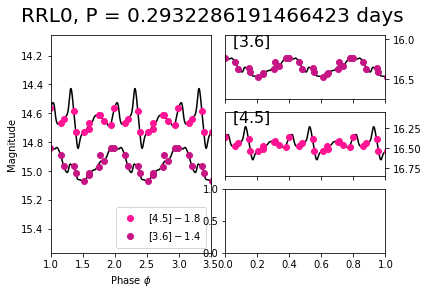

mean_mag_ch1 = 16.351838
amplitude_ch1 = 0.23083286
mean_mag_ch2 = 16.446748
amplitude_ch2 = 0.41477548


In [14]:
## GLOESS LIGHT CURVES ##

# OPTIONS
cluster       = 'PAL5'
channel       = '4p5um'
epoch_path    = 'PAL5_data/*/'
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

main_file_ch1 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_3p6um.txt'
main_file_ch2 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_4p5um.txt'

main_table1 = ascii.read(main_file_ch1, delimiter = ',', data_start = 1)
main_table2 = ascii.read(main_file_ch2, delimiter = ',', data_start = 1)

## REDO LIGHT CURVE X AXIS TO AVOID RUNNING ABOVE CODE ##
lctime = []

for file in glob.glob(path1) + glob.glob(path2):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

## USING VARIABLE STAR CATALOGUE ##
## ________ ##
## NOTE: REFER TO CHANNEL VISIBILITY OF TARGET RRLs ##
rrl = 0

ch1_rrls = [0, 2, 4]
ch2_rrls = [0, 1, 2, 3, 4]

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main1 = SkyCoord(main_table1['ra'], main_table1['dec'], unit = u.degree)
coord_main2 = SkyCoord(main_table2['ra'], main_table2['dec'], unit = u.degree)

## READ IN GAIA DATA FOR STARS <10ARCMIN OF PAL5 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL5_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print(gaia_data['source_id', 'ra', 'dec'])

coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## EXTRACTING USER RRL IN CATALOGUE AND SEARCHING GAIA ##

target_rrl = rrl
c = coord_rrl[target_rrl]

source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)

gaia_source = gaia_data[source_id]['source_id']
print('Gaia source_id = {0}\n'.format(gaia_source))

## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
votable = parse_single_table(vot_file1).to_table()
gaia_main = votable

## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

for idx in range(len(gaia_main)):
    if gaia_main[idx]['source_id'] == gaia_source:
        main_id = idx
print(gaia_main[main_id])
print('\n')
print(gaia_main[main_id]['best_classification'])
## EXTRACT PERIODS FROM GAIA DATA ##
## IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE ##

if type(gaia_main[main_id]['pf']) == np.float64:
    rrl_class = 'RRab'
    P = gaia_main[main_id]['pf']
    P_err = gaia_main[main_id]['pf_error']
elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
    pass
if type(gaia_main[main_id]['p1_o']) == np.float64:
    rrl_class = 'RRc'
    P = gaia_main[main_id]['p1_o']
    P_err = gaia_main[main_id]['p1_o_error']
elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
    pass
print('RRL classification: {0}\n'.format(rrl_class))
# note: implement a method for if both periods are avail?

# PERIOD OVERRIDE IF STAR NOT FOUND IN GAIA OR INCORRECTLY MATCHED
#P = 0.2864

## MATCH CATALOGUE TO MASTER SOURCE LIST ##

main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
main2_id, d2d, d3d = c.match_to_catalog_sky(coord_main2)

if target_rrl in ch1_rrls:
    print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
if target_rrl in ch2_rrls:
    print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))

phase = []

for i in lctime:
    func = i / P
    phase_val = func - np.floor(func)
    phase.append(phase_val)

## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
main_table1_m = copy.copy(main_table1.filled(99))
main_table2_m = copy.copy(main_table2.filled(99))

mag1 = []
unc1 = []
mag2 = []
unc2 = []

for i in range(1, 13):
    if target_rrl in ch1_rrls:
        mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
        unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
    if target_rrl in ch2_rrls:
        mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
        unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

av_1, am_1, av_2, am_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), 0)

print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}'.format(av_1, am_1, av_2, am_2))

#### GLOESSpy code but attempting to consider RRd type stars

     source_id              ra                 dec         
                           deg                 deg         
------------------- ------------------ --------------------
4418724034151291776  229.0395752980474 -0.27315259808741965
4418726027016125056 229.05318546815684 -0.16753341271842292
4418725232446508032  229.0104637260607  -0.2242677694891892
4418731829516302848 229.09705423020364  -0.1419234982327973
4418920808077110784 228.99266625761803 -0.09659804838365565
4418913218870688768 228.99144962264384 -0.18985356481473498
4418920846732620032 228.99634825110095 -0.08977613143985393
4418914863842345856 228.98840114088054 -0.11479928258025933
Gaia source_id = 4418914863842345856

     source_id       pf pf_error        p1_o              p1_o_error      p2_o p2_o_error best_classification
                     d     d             d                    d            d       d                         
------------------- --- -------- ------------------ --------------------- ---- ---

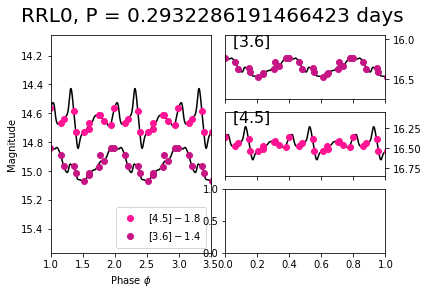

GLOESSpy results for P = 0.29322862:

mean_mag_ch1 = 16.351838
amplitude_ch1 = 0.23083286
mean_mag_ch2 = 16.446748
amplitude_ch2 = 0.41477548


In [25]:
## GLOESS LIGHT CURVES RRd CONSIDERATION ##

## GLOESS LIGHT CURVES ##

# OPTIONS
cluster       = 'PAL5'
channel       = '4p5um'
epoch_path    = 'PAL5_data/*/'
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

main_file_ch1 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_3p6um.txt'
main_file_ch2 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_4p5um.txt'

main_table1 = ascii.read(main_file_ch1, delimiter = ',', data_start = 1)
main_table2 = ascii.read(main_file_ch2, delimiter = ',', data_start = 1)

## REDO LIGHT CURVE X AXIS TO AVOID RUNNING ABOVE CODE ##
lctime = []

for file in glob.glob(path1) + glob.glob(path2):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

## USING VARIABLE STAR CATALOGUE ##
## ________ ##
## NOTE: REFER TO CHANNEL VISIBILITY OF TARGET RRLs ##
rrl = 0

ch1_rrls = [0, 2, 4]
ch2_rrls = [0, 1, 2, 3, 4]

# MULTI = 0 -> STAR NOT IN BOTH LISTS
# MULTI = 1/TRUE -> STAR IN BOTH LISTS
multi = 1

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main1 = SkyCoord(main_table1['ra'], main_table1['dec'], unit = u.degree)
coord_main2 = SkyCoord(main_table2['ra'], main_table2['dec'], unit = u.degree)

## READ IN GAIA DATA FOR STARS <10ARCMIN OF PAL5 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL5_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print(gaia_data['source_id', 'ra', 'dec'])

coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## EXTRACTING USER RRL IN CATALOGUE AND SEARCHING GAIA ##

target_rrl = rrl
c = coord_rrl[target_rrl]

source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)

gaia_source = gaia_data[source_id]['source_id']
print('Gaia source_id = {0}\n'.format(gaia_source))

## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
votable = parse_single_table(vot_file1).to_table()
gaia_main = votable

## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

for idx in range(len(gaia_main)):
    if gaia_main[idx]['source_id'] == gaia_source:
        main_id = idx
print(gaia_main[main_id])
print('\n')

## EXTRACT PERIODS FROM GAIA DATA ##
## IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE OR BOTH ##

if gaia_main[main_id]['best_classification'] == b'RRd':
    if type(gaia_main[main_id]['pf']) == np.float64:
        P0 = gaia_main[main_id]['pf']
        P0_err = gaia_main[main_id]['pf_error']
    elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
        pass
    if type(gaia_main[main_id]['p1_o']) == np.float64:
        P1 = gaia_main[main_id]['p1_o']
        P1_err = gaia_main[main_id]['p1_o_error']
    elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
        pass
    print('RRL has two periods: P0 = {0:.8g} and P1 = {1:.8g}\n'.format(P0, P1))
    # note: implement a method for if both periods are avail?

    # PERIOD OVERRIDE IF STAR NOT FOUND IN GAIA OR INCORRECTLY MATCHED
    #P = 0.2864

    ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

    main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
    main2_id, d2d, d3d = c.match_to_catalog_sky(coord_main2)

    if target_rrl in ch1_rrls:
        print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
    if target_rrl in ch2_rrls:
        print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))

    #phase = []

    #for i in lctime:
    #    func = i / P
    #    phase_val = func - np.floor(func)
    #    phase.append(phase_val)

    ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
    main_table1_m = copy.copy(main_table1.filled(99))
    main_table2_m = copy.copy(main_table2.filled(99))

    mag1 = []
    unc1 = []
    mag2 = []
    unc2 = []

    for i in range(1, 13):
        if target_rrl in ch1_rrls:
            mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
            unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
        if target_rrl in ch2_rrls:
            mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
            unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

    av_1a, am_1a, av_2a, am_2a = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P0, 'RRL'+str(target_rrl), multi)
    print('GLOESSpy results for P0 = {0:.8g}:\n'.format(P0))
    print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}\n'.format(av_1a, am_1a, av_2a, am_2a))
    
    av_1b, am_1b, av_2b, am_2b = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P1, 'RRL'+str(target_rrl), multi)
    print('GLOESSpy results for P1 = {0:.8g}:\n'.format(P1))
    print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}\n'.format(av_1b, am_1b, av_2b, am_2b))
elif gaia_main[main_id]['best_classification'] != b'RRd':
    if type(gaia_main[main_id]['pf']) == np.float64:
        rrl_class = 'RRab'
        P = gaia_main[main_id]['pf']
        P_err = gaia_main[main_id]['pf_error']
    elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
        pass
    if type(gaia_main[main_id]['p1_o']) == np.float64:
        rrl_class = 'RRc'
        P = gaia_main[main_id]['p1_o']
        P_err = gaia_main[main_id]['p1_o_error']
    elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
        pass
    print('RRL classification: {0}\n'.format(rrl_class))
    # note: implement a method for if both periods are avail?

    # PERIOD OVERRIDE IF STAR NOT FOUND IN GAIA OR INCORRECTLY MATCHED
    #P = 0.2864

    ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

    main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
    main2_id, d2d, d3d = c.match_to_catalog_sky(coord_main2)

    if target_rrl in ch1_rrls:
        print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
    if target_rrl in ch2_rrls:
        print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))

    phase = []

    for i in lctime:
        func = i / P
        phase_val = func - np.floor(func)
        phase.append(phase_val)

    ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
    main_table1_m = copy.copy(main_table1.filled(99))
    main_table2_m = copy.copy(main_table2.filled(99))

    mag1 = []
    unc1 = []
    mag2 = []
    unc2 = []

    for i in range(1, 13):
        if target_rrl in ch1_rrls:
            mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
            unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
        if target_rrl in ch2_rrls:
            mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
            unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

    av_1, am_1, av_2, am_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), 0)
    print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
    print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nmean_mag_ch2 = {2:.8g}\namplitude_ch2 = {3:.8g}'.format(av_1, am_1, av_2, am_2))

#### Building PL relation
Note: to-do<br>
1) extract mean_mags from previous run of GLOESS alongside period<br>
2) build a list of mags and periods for: channel 1 only, channel 2 only, combined channel 1 and 2<br>
3) fundamentalise period values<br>
4) plot y = mag, x = log(P) and fit Map = a2 + b(log(P) + 0.3)<br>
5) obtain distances from a2 - a1 = Mabs - Map = distance modulo

In [17]:
## CHANNEL 1 ONLY ##
av_mag1 = []
P_1 = []
## CHANNEL 2 ONLY ##
av_mag2 = []
P_2 = []
## BOTH CHANNELS ##
av_magb = []
P_b = []

In [24]:
av_mag1.append(av_1)
P_1.append(P)

print(av_mag1)
print(P_1)

[16.35183798191105, 16.173395158192516, 16.283844917271594]
[0.2932286191466423, 0.32994609655420243, 0.3379328972183922]


In [37]:
P_FO = []
P_FO = np.log10(P_1)
P_F = P_FO + 0.127
log_P = P_F + 0.3

b = -2.78 # channel 1

def func(a, P):
    return a + b * (np.log(P_F) + 0.3)

popt, pcov = curve_fit(func, P_F, av_mag1)
print(popt)

slope = popt[0]
intercept = popt[1]
unc_slope = np.sqrt(float(pcov[0][0]))
unc_intercept = np.sqrt(flot(pcov[1][1]))

plt.plot(log_P, av_mag1)
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation: CHANNEL 1')
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 12)
plt.show()

C:\Users\lukeb\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 400.

In [ ]:
'''## OBSOLETE DO NOT USE ##'''

## LIGHT CURVE ANALYSIS: PAL5 3p6um DATA ##
##_______________________________________##

# OPTIONS
cluster_input = 'PAL5'
channel       = '3p6um'
epoch_path    = 'PAL5_data/*/'
main_file = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster_input+'_main_phot_'+channel+'.txt'
path1, path2 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'
rrl = 2 # 0 to 4 for PAL5

def light_curve(cluster, channel, epoch_path, path1, path2, main_file, rrl):
    global main_table, lctime, P
    main_file = main_file
    main_table = ascii.read(main_file, delimiter = ',', data_start = 1)
    
    lctime = []
    
    for file in glob.glob(path1) + glob.glob(path2):
        with fits.open(file) as hdr_list:
            e_hdr = hdr_list[0].header
            lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
        
    rrl_cat = 'CCVS_data/CCVS_'+cluster+'_RRLs_data.txt'
    df_cat = ascii.read(rrl_cat, delimiter = ',', data_start = 1)
    
    df_cat['ra_deg'] = str('null')
    df_cat['dec_deg'] = str('null')
    
    for col in df_cat.itercols():
        if col.dtype.kind in 'SU':
            df_cat.replace_column(col.name, col.astype('object'))
            
    for i in range(len(df_cat)):
        ra_hms = Angle(df_cat['ra'][i], u.hour)
        df_cat['ra_deg'][i] = ra_hms.to_string(unit = u.deg, decimal = True)
    for i in range(len(df_cat)):
        dec_hms = Angle(df_cat['dec'][i], u.degree)
        df_cat['dec_deg'][i] = dec_hms.to_string(unit = u.deg, decimal = True)
        
    df_cat.write('CCVS_data/CCVS_{0}_RRLs_data_readin.txt'.format(cluster), format = 'csv', overwrite = True)
    
    cc_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
    coord_rrl = SkyCoord(cc_cat['ra_deg'], cc_cat['dec_deg'], unit = u.degree)
    coord_cat = SkyCoord(main_table['ra'], main_table['dec'], unit = u.degree)
    
    req_rrl = rrl
    c = coord_rrl[req_rrl]
    
    seps = []
    for i in range(len(coord_cat)):
        seps.append(coord_cat[i].separation(c).value)

    id_rrl = np.asarray(seps).argmin()
    
    P = cc_cat['period'][req_rrl]
    
    return id_rrl

id_rrl = light_curve(cluster_input, channel, epoch_path, path1, path2, main_file, rrl)

# EXTRACT MAGNITUDES AND UNCERTAINTIES
mag = []
mag_err = []

for i in range(1, 13):
    epoch = i
    mag.append(main_table[id_rrl]['mag_e'+str(i)])
    mag_err.append(main_table[id_rrl]['unc_e'+str(i)])
print(mag)
print(mag_err)
# CONVERT JD TO PHASE

phase = []

for i in lctime:
    func = i / P
    phase_val = func - np.floor(func)
    phase.append(phase_val)
print(phase)
mag = np.ma.array(mag)
mag = np.ma.masked_where(mag == -99, mag)
mag_err = np.ma.array(mag_err)
mag_err = np.ma.masked_where(mag_err == -99, mag_err)
phase = np.ma.masked_array(phase, mag.mask)
mag_long = np.concatenate((mag, mag, mag))
unc_long = np.concatenate((mag_err, mag_err, mag_err))
phase_long = np.concatenate((phase, phase + 1., phase + 2.))

plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 5, capsize = 5)
plt.xlabel('Phase ϕ')
plt.ylabel('Apparent magnitude')
plt.title('STAR ID{0}, for RRL{1} in channel {2}'.format(id_rrl, rrl, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 12)
plt.show()

In [ ]:
'''## OBSOLETE DO NOT USE ##'''

## LIGHT CURVE ANALYSIS: PAL5 3p6um DATA ##
##_______________________________________##

# OPTIONS
cluster_input = 'PAL5'
channel       = '3p6um'
epoch_path    = 'PAL5_data/*/'
    
## READ IN MAIN FILE ##

main_file = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster_input+'_main_phot_'+channel+'.txt'
main_table = ascii.read(main_file, delimiter = ',', data_start = 1)
print(main_file)
## EXTRACTING LCTIME ##

path1 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits'
path2 = epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'

lctime = []

for file in glob.glob(path1, recursive = True) + glob.glob(path2, recursive = True):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
## BASIC METHOD ##
# CATALOGUE INPUT DATA 
RRL_id = 3
rahms_cat = Angle('15:15:58.23', u.hour)
dechms_cat = Angle('-00:05:47.4', u.degree)
P = 0.2524

# CONVERT TO DECIMAL
ra_cat = rahms_cat.to_string(unit = u.deg, decimal = True)
dec_cat = dechms_cat.to_string(unit = u.deg, decimal = True)
print('RRL {0}: RA = {1}, dec = {2}'.format(RRL_id, ra_cat, dec_cat))

# MANUALLY FINDING RRL
#main_tableid = 95
#main_tableid = 24
main_tableid = 554


# EXTRACT MAGNITUDES AND UNCERTAINTIES
mag = []
mag_err = []

for i in range(1, 13):
    epoch = i
    mag.append(main_table[main_tableid]['mag_e'+str(i)])
    mag_err.append(main_table[main_tableid]['unc_e'+str(i)])
print(mag)
print(mag_err)
# CONVERT JD TO PHASE

phase = []

for i in lctime:
    func = i / P
    phase_val = func - np.floor(func)
    phase.append(phase_val)
print(phase)
mag = np.ma.array(mag)
mag = np.ma.masked_where(mag == -99, mag)
mag_err = np.ma.array(mag_err)
mag_err = np.ma.masked_where(mag_err == -99, mag_err)
phase = np.ma.masked_array(phase, mag.mask)
mag_long = np.concatenate((mag, mag, mag))
unc_long = np.concatenate((mag_err, mag_err, mag_err))
phase_long = np.concatenate((phase, phase + 1., phase + 2.))

plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 5, capsize = 5)
#plt.xlabel['a']
#plt.ylabel['Apparent magnitude']
plt.title('STAR ID{0}, for RRL{1}'.format(main_tableid, RRL_id))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 12)
plt.show()